# Prepare Dataset

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch.optim as optim
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import xgboost as xgb
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def merge_datasets(flight_path="2016.csv", weather_path="2016_weather.csv") -> tuple:
    flight_df = pd.read_csv(flight_path)
    weather_df = pd.read_csv(weather_path)

    # self._preprocess_datetime()

    # Merge the two dataframes on the date and time columns
    merged_df = pd.merge(flight_df, weather_df, how='right', on=["Rounded Datetime", "Air Temperature", "Dew Temperature", "Sea Level Pressure", "Wind Direction", "Wind Speed Rate", "Precip 1 Hour", "Sky Condition"])

    return merged_df

## The Goal

Design an AI, which:

- Receives as inputs a sequence of weather features (a step further from the original just temperature of HW3)

- Outputs the predicted delay

In [ ]:
class CustomFlightDataset(Dataset):
    def __init__(self, flight_csv, weather_csv, hours_before=5, transform=None, target_col='Departure Delay (Minutes)', test_size=0.0, random_state=42):
        self.hours_before = hours_before
        self.transform = transform
        self.target_col = target_col

        self.flight_df = pd.read_csv(flight_csv)
        self.weather_df = pd.read_csv(weather_csv)

        print(f"csv size:{len(self.flight_df)} and {len(self.weather_df)}")
        self._preprocess_datetime()

        self.data = self._create_combined_dataset() # Create combined dataset with time-window features


        self.data = self.data.dropna()


        if len(self.data) == 0:
            raise Valueerror("No valid data after combining flight and weather data. Check datetime alignment")

        self.features = self.data.drop([target_col], axis=1) # Drop column
        self.targets = self.data[target_col].values

        self._process_features()

        if test_size > 0:
            self._train_test_split(test_size, random_state)

    def _preprocess_datetime(self):
        """Preprocess datetime columns"""
        self.flight_df['Scheduled Departure Datetime'] = pd.to_datetime(self.flight_df['Scheduled Departure Datetime'])
        self.flight_df['Rounded Datetime'] = pd.to_datetime(self.flight_df['Rounded Datetime'])
        self.weather_df['Rounded Datetime'] = pd.to_datetime(self.weather_df['Rounded Datetime'])

        self.weather_df = self.weather_df.sort_values('Rounded Datetime')
        print(f"csv size post datetime preprocess:{len(self.flight_df)} and {len(self.weather_df)}")

    def _extract_weather_features(self, departure_datetime):

        start_time = departure_datetime - timedelta(hours=self.hours_before)

        weather_window = self.weather_df[
            (self.weather_df['Rounded Datetime'] >= start_time) &
            (self.weather_df['Rounded Datetime'] <= departure_datetime)
        ] # never knew you can filter like this

        if len(weather_window) == 0:
            return None

        weather_cols = ['Air Temperature', 'Dew Temperature', 'Sea Level Pressure',
                       'Wind Direction', 'Wind Speed Rate', 'Precip 1 Hour']

        weather_features = {}
        for col in weather_cols:
            if col != 'Sky Condition':
                weather_features[f"{col}_mean"] = weather_window[col].mean()
                weather_features[f"{col}_max"] = weather_window[col].max()
                weather_features[f"{col}_min"] = weather_window[col].min()
                weather_features[f"{col}_std"] = weather_window[col].std()

        if 'Sky Condition' in weather_window.columns:
            weather_features['Sky Condition'] = weather_window['Sky Condition'].mode()[0]

        return weather_features

    def _create_combined_dataset(self):
        combined_data = []

        for _, flight in self.flight_df.iterrows():

            weather_features = self._extract_weather_features(flight['Scheduled Departure Datetime'])
            if weather_features is None:
                continue

            flight_features = {
                'Carrier_Code': flight['Carrier Code'],
                    'Flight_Number': float(flight['Flight Number']),
                    'Destination_Airport': flight['Destination Airport'],
                    'Hour_of_Day': flight['Scheduled Departure Datetime'].hour,
                    'Day_of_Week': flight['Scheduled Departure Datetime'].dayofweek,
                    'Month': flight['Scheduled Departure Datetime'].month
            }

            combined_row = {
                **flight_features,
                **weather_features,
                self.target_col: flight[self.target_col]
            }

            combined_data.append(combined_row)

        return pd.DataFrame(combined_data)

    def _process_features(self):

        categorical_cols = ['Carrier Code', 'Destination Airport', 'Sky Condition']
        categorical_cols = [col for col in categorical_cols if col in self.features.columns]

        numerical_cols = [col for col in self.features.columns if col not in categorical_cols and pd.api.types.is_numeric_dtype(self.features[col])]

        transformers = []

        if numerical_cols:
            numerical_transformer = Pipeline(steps=[
                ('scaler', StandardScaler())
            ])
            transformers.append(('num', numerical_transformer, numerical_cols))

        if categorical_cols:
            categorical_transformer = Pipeline(steps=[
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
            transformers.append(('cat', categorical_transformer, categorical_cols))

        self.preprocessor = ColumnTransformer(transformers=transformers)

        self.X = self.preprocessor.fit_transform(self.features)

    def _train_test_split(self, test_size, random_state): # has problem if test_size > 0
        from sklearn.model_selection import train_test_split

        indices = np.arange(len(self.X))
        train_indices, test_indices = train_test_split(
            indices, test_size=test_size, train_size=(1-test_size), random_state=random_state
        )
        self.train_indices = train_indices
        self.test_indices = test_indices

    def get_feature_names(self):
        if hasattr(self, 'preprocessor'):
            return self.preprocessor.get_feature_names_out()
        return self.features.columns.tolist()

    def get_test_dataset(self):
        if not hasattr(self, 'test_indices'):
            raise ValueError("No test indices available. Create dataset with test_size > 0")

        test_dataset = FlightWeatherDatasetSplit(
            self.X[self.test_indices],
            self.targets[self.test_indices],
            transform=self.transform
        )
        return test_dataset

    def get_train_dataset(self):
            """Get a training dataset using the train indices."""
            if not hasattr(self, 'train_indices'):
                raise ValueError("No train indices available. Create dataset with test_size > 0")

            train_dataset = FlightWeatherDatasetSplit(
                self.X[self.train_indices],
                self.targets[self.train_indices],
                transform=self.transform
            )
            return train_dataset

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
            X = torch.FloatTensor(self.X[idx])
            y = torch.FloatTensor([self.targets[idx]])

            if self.transform:
                X = self.transform(X)

            return X, y

In [ ]:
class FlightWeatherDatasetSplit(Dataset):
    """Helper class for train/test splits of the main dataset."""

    def __init__(self, features, targets, transform=None):
        self.features = features
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        X = torch.FloatTensor(self.features[idx])
        y = torch.FloatTensor([self.targets[idx]])

        if self.transform:
            X = self.transform(X)

        return X, y


In [ ]:
flight_path = '2016.csv'
weather_path = '2016_weather.csv'

dataset = CustomFlightDataset(
    flight_csv=flight_path,
    weather_csv=weather_path,
    test_size=0.1
)



csv size:30263 and 8782
csv size post datetime preprocess:30263 and 8782


In [ ]:
train_dataset = dataset.get_train_dataset()
test_dataset = dataset.get_test_dataset()


In [ ]:
print(f"Training set: {len(train_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")
# print(dataset.data.head())

Training set: 27236 samples
Test set: 3027 samples


In [ ]:
batch_size=16
generator = torch.Generator(device=device)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator = torch.Generator(device='cpu')
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    generator = torch.Generator(device='cpu')
)

# Prediction (LSTM)

In [ ]:
class FlightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=4, dropout=0.2):
        super(FlightLSTM, self).__init__()

        self.lstm  = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout if num_layers > 1 else 0
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, -1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:,-1,:]
        output = self.fc(lstm_out)
        return output

In [ ]:
class SequenceWrapper(nn.Module):
    """
    Wrapper to reshape inputs for sequence models when using non-sequential datasets.
    Allows using the same dataset class with different model architectures.
    """
    def __init__(self, model):
        super(SequenceWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

In [ ]:
def train_lstm_model(model, train_loader, test_loader, input_size, device='cuda'):
    """Train an LSTM model for flight delay prediction."""


    # Loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    # Training loop
    num_epochs = 50
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        # Learning rate scheduler step
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_lstm_model.pth')

        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best model
    model.load_state_dict(torch.load('best_lstm_model.pth'))

    return model, train_losses, val_losses

In [ ]:
input_size = dataset.X.shape[1]
model = FlightLSTM(input_size=input_size)
model.to(device)
model = SequenceWrapper(model).to(device)
print(device)
train_lstm_model(model, train_loader=train_loader, test_loader=test_loader, input_size=input_size, device=device)

cuda
Epoch 5/50, Train Loss: 16.6794, Val Loss: 17.5334
Epoch 10/50, Train Loss: 16.3717, Val Loss: 17.2949
Epoch 15/50, Train Loss: 16.2948, Val Loss: 17.0000
Epoch 20/50, Train Loss: 16.0360, Val Loss: 16.8545
Epoch 25/50, Train Loss: 15.9959, Val Loss: 16.6687
Epoch 30/50, Train Loss: 15.8550, Val Loss: 16.7768
Epoch 35/50, Train Loss: 15.7685, Val Loss: 16.5930
Epoch 40/50, Train Loss: 15.6940, Val Loss: 16.4881
Epoch 45/50, Train Loss: 15.6094, Val Loss: 16.4112
Epoch 50/50, Train Loss: 15.5470, Val Loss: 16.3162


(SequenceWrapper(
   (model): FlightLSTM(
     (lstm): LSTM(50, 64, num_layers=4, dropout=0.2)
     (fc): Sequential(
       (0): Linear(in_features=64, out_features=32, bias=True)
       (1): ReLU()
       (2): Dropout(p=0.2, inplace=False)
       (3): Linear(in_features=32, out_features=1, bias=True)
     )
   )
 ),
 [17.23934085188511,
  17.022237215613313,
  16.881450234898665,
  16.757305781279882,
  16.679387454208175,
  16.607128164170422,
  16.544118049210546,
  16.472457499064493,
  16.42836494090203,
  16.371676770505385,
  16.302495386764292,
  16.326385888084552,
  16.324466952700792,
  16.268774888267675,
  16.294837417843336,
  16.188142911448452,
  16.20836561368762,
  16.140408075212804,
  16.09356302201433,
  16.03596151974085,
  16.096213224139973,
  16.02602088388386,
  16.072643792286243,
  16.04049771824656,
  15.99588789340684,
  15.978864972058004,
  15.955506279548336,
  15.926441102327491,
  15.92212763269439,
  15.854999752235077,
  15.930708716423878,
  15.87

In [ ]:
pretrained_model_weight = 'best_lstm_model.pth'
model = FlightLSTM(input_size=input_size)
model.load_state_dict(torch.load(pretrained_model_weight), strict=False)
# model.eval()
print(model)

FlightLSTM(
  (lstm): LSTM(45, 64, num_layers=3, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
flight_path = '2017.csv'
weather_path = '2017_weather.csv'

dataset = CustomFlightDataset(
    flight_csv=flight_path,
    weather_csv=weather_path,
    test_size=0.1
)
train_dataset = dataset.get_train_dataset()
test_dataset = dataset.get_test_dataset()
batch_size=64
generator = torch.Generator(device=device)
print(device)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator = torch.Generator(device='cpu')
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    generator = torch.Generator(device='cpu')
)

input_size = dataset.X.shape[1]
print(device)
train_lstm_model(model, train_loader=train_loader, test_loader=test_loader, input_size=input_size, device=device)

csv size:29595 and 8759
csv size post datetime preprocess:29595 and 8759
cuda
cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/50, Train Loss: 19.0541, Val Loss: 20.2711
Epoch 10/50, Train Loss: 18.8430, Val Loss: 20.1224
Epoch 15/50, Train Loss: 18.5561, Val Loss: 19.8313
Epoch 20/50, Train Loss: 18.4888, Val Loss: 19.7717
Epoch 25/50, Train Loss: 18.3721, Val Loss: 19.6787
Epoch 30/50, Train Loss: 18.2598, Val Loss: 19.8483
Epoch 35/50, Train Loss: 18.1586, Val Loss: 19.7694
Epoch 40/50, Train Loss: 18.0742, Val Loss: 19.7421
Epoch 45/50, Train Loss: 17.9954, Val Loss: 19.6681
Epoch 50/50, Train Loss: 17.9841, Val Loss: 19.7168


(SequenceWrapper(
   (model): FlightLSTM(
     (lstm): LSTM(45, 64, num_layers=3, dropout=0.2)
     (fc): Sequential(
       (0): Linear(in_features=64, out_features=32, bias=True)
       (1): ReLU()
       (2): Dropout(p=0.2, inplace=False)
       (3): Linear(in_features=32, out_features=1, bias=True)
     )
   )
 ),
 [19.679994411605726,
  19.414773495077227,
  19.231923031292375,
  19.158585520957015,
  19.054139292783304,
  19.02551162385826,
  18.985413826912712,
  18.887819636639932,
  18.789009497891797,
  18.843022600352334,
  18.71691384704279,
  18.702438252721187,
  18.648185437245907,
  18.640382460267137,
  18.55609321822937,
  18.579683154035244,
  18.550264436278127,
  18.500704251890845,
  18.454314823059157,
  18.488792700733214,
  18.394588397275342,
  18.419698779245646,
  18.422118052018345,
  18.351716129614008,
  18.3721335774703,
  18.29731387886212,
  18.324016699116292,
  18.331179241482303,
  18.276580321131277,
  18.259783549274474,
  18.266343884044986,
  18

# Prediction (Pre-trained)

In [ ]:
class PretrainedFlightModel(nn.Module):
    def __init__(self, input_size, pretrained_weights=None):
        super(PretrainedFlightModel, self).__init__()

        # Encoder (would be pre-trained in a real scenario)
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

        # Prediction head (to be fine-tuned)
        self.prediction_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        if pretrained_weights:
            self.load_state_dict(torch.load(pretrained_weights))

            for param in self.encoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        features = self.encoder(x)
        output = self.prediction_head(features)
        return output

    def unfreeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = True



# Prediction (XGBoost)

In [ ]:
def train_xgboost_model(train_dataset, test_dataset):
    X_train = train_dataset.features
    y_train = train_dataset.targets

    X_test = test_dataset.features
    y_test = test_dataset.targets

    # Define XGBoost parameters
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.05,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'eval_metric': 'rmse',
        'seed': 42
    }

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define watchlist for evaluation
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]

    # Train model
    print("Training XGBoost model...")
    xgb_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=200,
        evals=watchlist,
        early_stopping_rounds=20,
        verbose_eval=10
    )

    # Save model
    xgb_model.save_model('flight_delay_xgboost.model')

    # Make predictions
    y_pred = xgb_model.predict(dtest)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"XGBoost Test Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(xgb_model, max_num_features=15)
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.savefig('xgboost_feature_importance.png')

    return xgb_model, y_pred, y_test




Training XGBoost model...
[0]	train-rmse:47.97876	eval-rmse:52.44611
[10]	train-rmse:44.05037	eval-rmse:49.19502
[20]	train-rmse:41.92346	eval-rmse:47.83315
[30]	train-rmse:40.54921	eval-rmse:46.95268
[40]	train-rmse:39.45550	eval-rmse:46.51398
[50]	train-rmse:38.75075	eval-rmse:46.31566
[60]	train-rmse:38.19038	eval-rmse:46.16042
[70]	train-rmse:37.61251	eval-rmse:46.05283
[80]	train-rmse:37.21775	eval-rmse:45.99297
[90]	train-rmse:36.82624	eval-rmse:45.92703
[100]	train-rmse:36.55884	eval-rmse:45.86274
[110]	train-rmse:36.22722	eval-rmse:45.78983
[120]	train-rmse:35.94384	eval-rmse:45.78190
[130]	train-rmse:35.68104	eval-rmse:45.76696
[140]	train-rmse:35.43482	eval-rmse:45.67641
[150]	train-rmse:35.20215	eval-rmse:45.66551
[160]	train-rmse:34.97546	eval-rmse:45.65189
[170]	train-rmse:34.77322	eval-rmse:45.60518
[180]	train-rmse:34.57905	eval-rmse:45.59449
[190]	train-rmse:34.43222	eval-rmse:45.58965
[199]	train-rmse:34.26847	eval-rmse:45.62218
XGBoost Test Metrics:
MSE: 2081.3835
RMS

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:54:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


(<xgboost.core.Booster at 0x7df495e8c710>,
 array([17.093748  , -0.14159337, 15.5651655 , ...,  3.2336142 ,
         4.543663  ,  7.633533  ], dtype=float32),
 array([-1., -4., 26., ..., -7.,  6., -3.]))

<Figure size 1000x600 with 0 Axes>

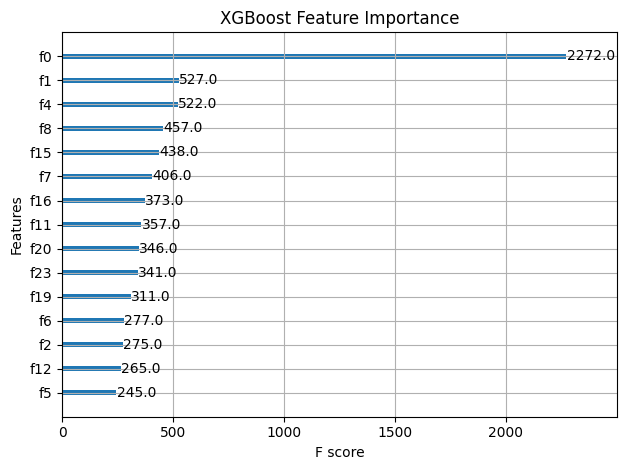

In [ ]:
train_xgboost_model(train_dataset, test_dataset)